Here, we want to know the model with the best explanatory power, compared to the rest.

## Requirements

```bash

mamba create -n acnets_bambi
mamba activate acnets_bambi
mamba install python ipykernel
pip install watermark bambi xarray netcdf4 seaborn
# pip install bokeh
```

In [1]:
import bambi
import arviz as az
import xarray as xr
import re
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
results = xr.open_dataset('models/connectivity_classifiers_top6.nc').load()
split_score_cols = [c for c in list(results.keys()) if re.match(r'split\d+_test_score', c)]
grid_cv_results = results[split_score_cols + ['rank_test_score', 'mean_test_score']].to_pandas()
grid_cv_results.index.name = 'label'
grid_cv_results = grid_cv_results.reset_index()

scores = grid_cv_results
# scores['label'] = scores['params'].apply(lambda p: _create_label(list(p.values())))
split_score_cols = [c for c in scores.columns if 'split' in c]
scores['test_score'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
scores = scores.explode('test_score').reset_index(drop=True)
scores = scores.sort_values('rank_test_score', ascending=False)
scores['label'] = scores['label'].apply(lambda x: x.replace('partial correlation', 'partial_correlation'))

scores[['atlas','kind']] = scores['label'].apply(lambda x: x.split(' ')).apply(pd.Series)
scores = scores[['atlas', 'kind', 'test_score']]

In [3]:
model = bambi.Model('test_score ~ 0 + atlas * kind', scores)
fitted = model.fit(tune=100, draws=200, init='adapt_diag')

az.summary(fitted).sort_values('mean', ascending=False)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [atlas, kind, atlas:kind, test_score_sigma]


Sampling 4 chains for 100 tune and 200 draw iterations (400 + 800 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8871, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9058, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8993, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
atlas[dosenbach2010],3.832,0.131,3.582,4.085,0.005,0.004,593.0,465.0,1.01
atlas[gordon2014_2mm],3.283,0.125,3.024,3.491,0.005,0.003,702.0,559.0,1.00
atlas[difumo_64_2mm],2.579,0.127,2.342,2.821,0.007,0.005,302.0,483.0,1.01
test_score_sigma,1.229,0.023,1.189,1.273,0.001,0.001,744.0,593.0,1.01
kind[partial_correlation],0.614,0.174,0.337,0.977,0.009,0.007,335.0,340.0,1.01
"atlas:kind[gordon2014_2mm, tangent]",0.609,0.256,0.134,1.068,0.014,0.010,343.0,525.0,1.01
kind[precision],0.605,0.174,0.289,0.934,0.009,0.007,346.0,539.0,1.01
kind[covariance],0.377,0.179,0.046,0.710,0.009,0.007,365.0,476.0,1.01
"atlas:kind[dosenbach2010, covariance]",0.368,0.251,-0.130,0.815,0.014,0.010,324.0,476.0,1.01
"atlas:kind[dosenbach2010, tangent]",0.250,0.269,-0.238,0.767,0.016,0.012,283.0,381.0,1.02


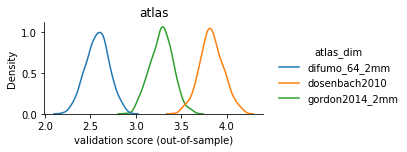

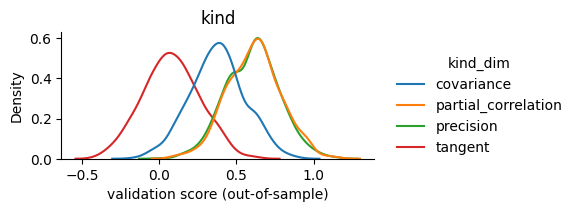

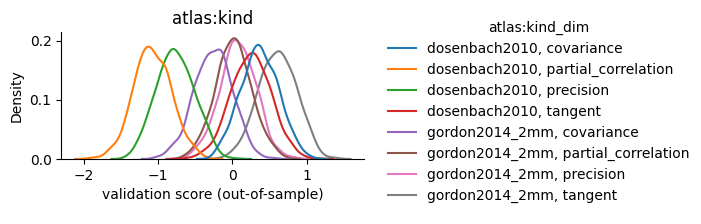

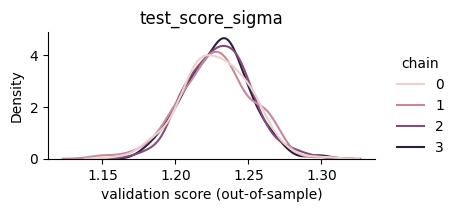

In [4]:
fitted['posterior']['atlas']

import seaborn as sns

for var_name in fitted['posterior'].data_vars:
    plot_data = fitted['posterior'][var_name].to_dataframe().reset_index()
    hue_dim = 0 if 'test_score_sigma' in var_name else 2
    g = sns.displot(data=plot_data,
                    x=var_name,
                    hue=fitted['posterior'][var_name].dims[hue_dim],
                    height=2, aspect=2,
                    kind='kde')
    # g.ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
    g.set(xlabel='validation score (out-of-sample)')
    g.set(title=var_name)
    plt.show()


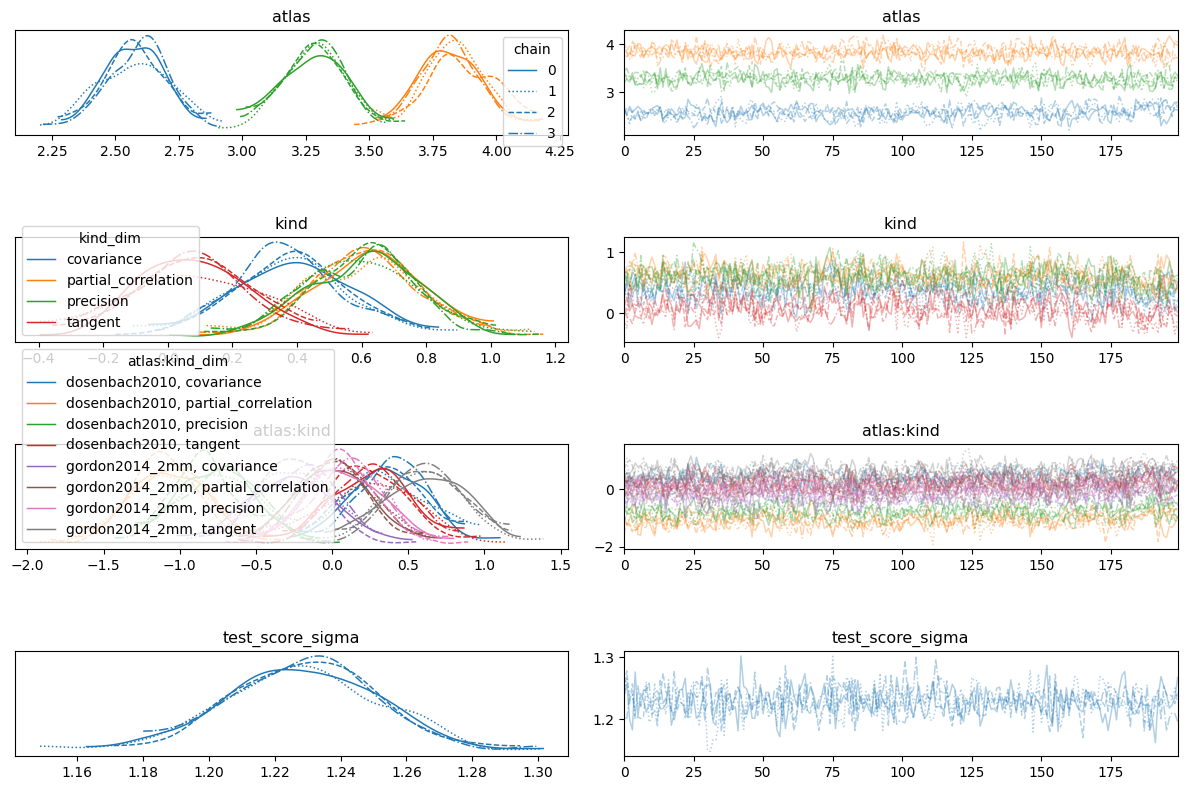

In [5]:
az.plot_trace(fitted, legend=True)

plt.tight_layout()
plt.show()

In [6]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Jul 12 2022

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

matplotlib: 3.5.2
sys       : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:09:13) [Clang 13.0.1 ]
re        : 2.2.1
arviz     : 0.12.1
xarray    : 2022.3.0
pandas    : 1.4.3
seaborn   : 0.11.2
bambi     : 0.9.0

Watermark: 2.3.1

